# Playground

Please read [1-Clement-introduction](1-Clement-introduction.ipynb) to understand the tools in use.

Just a playground for odyCy tests

In [1]:
import spacy
# Would require: pip install spacy pandas matplotlib
import pandas as pd
import matplotlib.pyplot as plt
from collections import Counter

In [2]:
clement_source = 'data/clement-i-greek.txt'
clement_file = open(clement_source, 'r')
clement_text = clement_file.read()

In [3]:
# Load the Ancient Greek model (update this to the actual name of your odyCY model)
nlp = spacy.load("grc_odycy_joint_trf")
doc = nlp(clement_text)

In [4]:
# Extract tokens with POS and Morphological features
data = [
    (token.text, token.lemma_, token.pos_, token.morph)
    for token in doc
    if token.is_alpha
]

df = pd.DataFrame(data, columns=["Token", "Lemma", "POS", "Morph"])

# 🔹 Count Verbs
verbs = df[df["POS"] == "VERB"]
print("Number of verbs:", len(verbs))

# 🔹 Extract Imperatives
imperatives = verbs[verbs["Morph"].apply(lambda m: "Mood=Imp" in str(m))]
print("\nImperatives found:")
print(imperatives)

# 🔹 Count Conjunctions
conjs = df[df["POS"] == "CCONJ"]
print("\nConjunctions found:")
print(conjs["Token"].value_counts())




Number of verbs: 1508

Imperatives found:
                 Token           Lemma   POS  \
183   ἐταπεινοφρονεῖτε  ἐταπεινοφρονέω  VERB   
576              ὁρᾶτε            ὁράω  VERB   
1092       Μετανοήσατε        Μετανοήω  VERB   
1142          Λούσασθε            Λούω  VERB   
1145           γένεσθε        γέγνομαι  VERB   
...                ...             ...   ...   
8695             ῥῦσαι          ῥύομαι  VERB   
8702               δὸς          δίδωμι  VERB   
8779               δός             δός  VERB   
8819         διεύθυνον       διεύθυνον  VERB   
9192        ἀναπέμψατε        ἀναπέμπω  VERB   

                                                  Morph  
183   (Mood=Imp, Number=Plur, Person=2, Tense=Pres, ...  
576   (Mood=Imp, Number=Plur, Person=2, Tense=Pres, ...  
1092  (Mood=Imp, Number=Plur, Person=2, Tense=Past, ...  
1142  (Mood=Imp, Number=Plur, Person=2, Tense=Past, ...  
1145  (Mood=Imp, Number=Plur, Person=2, Tense=Pres, ...  
...                              

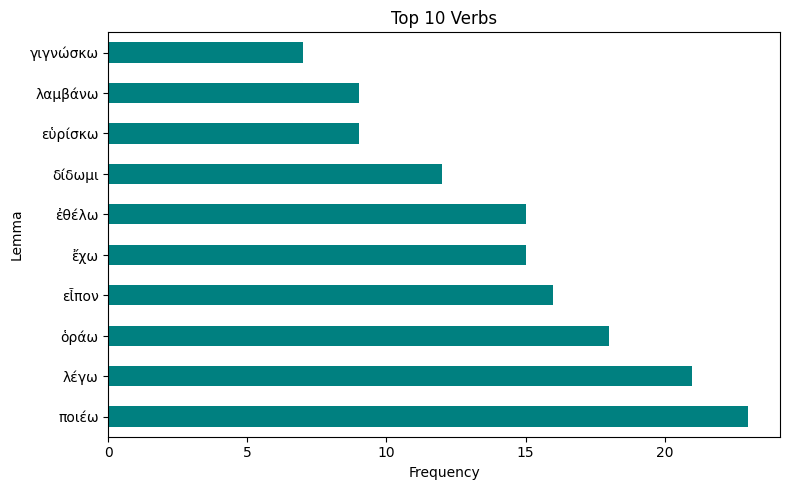

In [5]:
# 🔹 Plot verb lemmas frequency
verb_counts = verbs["Lemma"].value_counts().head(10)
verb_counts.plot(kind="barh", title="Top 10 Verbs", figsize=(8,5), color="teal")
plt.xlabel("Frequency")
plt.tight_layout()
plt.show()

# Word Embedding - just for verbs




In [6]:
def displayJson(data_payload):
    """
    Prints the key and the first value for each item in the first result
    of a dictionary payload.

    Args:
        data_payload (dict): The dictionary containing the 'results' key
                             with a list of dictionaries.
    """
    # Check if the payload is a dictionary and contains the 'results' key
    if not isinstance(data_payload, dict) or 'results' not in data_payload:
        print("Invalid payload format: Missing dictionary or 'results' key.")
        return

    results_list = data_payload['results']

    # Check if the 'results' list is not empty
    if not results_list:
        print("The 'results' list in the payload is empty.")
        return

    # Access the first item in the 'results' list
    first_result_item = results_list[0]

    # Check if the first item is a dictionary
    if not isinstance(first_result_item, dict):
        print("The first item in 'results' is not a dictionary.")
        return

    print("First values from the first result item:")
    # Iterate through the key-value pairs of the first item
    for key, value in first_result_item.items():
        first_value = None
        if isinstance(value, list) and value:
            # If the value is a non-empty list, take the first element
            first_value = value[0]
        elif isinstance(value, dict):
             # If the value is a dictionary, you might want to print the whole dict
             # or iterate through its items. For this function, let's print the dict.
             first_value = value # Or you could iterate: list(value.items())[0] if not empty
        else:
            # Otherwise, the value itself is the "first" value (for simple types like strings, numbers, booleans, null)
            first_value = value

        print(f"- {key}: {first_value}")

# Part 2: Detecting Scripture Quotations & Semantic Parallels
We’ll:

- Load your 1 Clement passage
- Load reference New Testament texts (in Ancient Greek)
- Use similarity scoring to identify likely quotations or paraphrases
- Using spaCy word embeddings (if the model supports them)
- Or fallback to fuzzy matching of token sequences or lemmatized text



In [11]:
from rapidfuzz import fuzz

In [12]:
# Sample New Testament verses (e.g. from Matthew and Luke)
nt_refs = {
    "Matthew 7:24": "πᾶς οὖν ὃς ἀκούει μου τοὺς λόγους τούτους καὶ ποιεῖ αὐτούς",
    "Luke 6:47": "πᾶς ὁ ἐρχόμενος πρός με καὶ ἀκούων μου τῶν λόγων καὶ ποιῶν αὐτούς",
    "John 14:15": "ἐὰν ἀγαπᾶτέ με, τὰς ἐντολὰς τὰς ἐμὰς τηρήσατε",
    "Matthew 26:24": "ούαί δέ τψ άνθρώπψ έκείνψ δι’ ού ό υιός τοϋ άνθρώπου παραδίδοται. καλόν ήν αύτφ εΐ ούκ έγεννήθη ό άνθρωπος έκεΐνος.",
    "Mark 14:21": "ούαί δέ τψ άνθρώπψ έκείνψ δι’ ού ό υιός τοϋ άνθρώπου παραδίδοται. καλόν αύτφ εΐ ούκ έγεννήθη ό άνθρωπος έκεΐνος.",
    "Luke 22:22": "πλήν ούαί τψ άνθρώπψ έκείνψ δι ού παραδίδοται.",
    "Matthew 18:6": "δς δ’ αν σκανδαλίση ένα τών μικρών τούτων τών πιστευόντων εις έμέ, συμφέρει αύτώ ϊνα κρεμασθή μύλος όνικός περί τόν τράχηλον αύτοϋ καί καταποντισθή έν τώ πελάγει τής θαλάσσης.",
    "Mark 9:42": "Καί δς αν σκανδαλίση ένα τών μικρών τούτων τών πιστευόντων, καλόν έστιν αύτω μάλλον εί περίκειται μύλος όνικός περί τόν τράχηλον αύτοϋ καί βέβληται εις τήν θάλασσαν.",
    "Luke 17:1": "άνένδεκτόν έστιν τοϋ τά σκάνδαλα μή έλθείν, ούαί δέ δι’ ού έρχεται' λυσιτελεί αύτψ εί λίθος μυλικός περίκειται περί τόν τράχηλον αύτού καί έρριπται εις τήν θάλασσαν, ή ϊνα σκανδαλίση τών μικρών τούτων ενα.",
    "false postive": "Ἡ ἐκκλησία τοῦ θεοῦ ἡ παροικοῦσα ῾Ρώμην τῇ ἐκκλησίᾳ τοῦ θεοῦ τῇ παροικούσῃ Κόρινθον"
}

In [13]:
# Function to compare similarity
def compare_fuzzy(source, targets):
    results = []
    for ref, text in targets.items():
        score = fuzz.partial_ratio(source, text)
        results.append((ref, score, text))
    return sorted(results, key=lambda x: x[1], reverse=True)

# Compare Clement to NT
results = compare_fuzzy(clement_text, nt_refs)

# Show top matches
for ref, score, match in results:
    print(f"{ref} ({score}):\n→ {match}\n")

false postive (100.0):
→ Ἡ ἐκκλησία τοῦ θεοῦ ἡ παροικοῦσα ῾Ρώμην τῇ ἐκκλησίᾳ τοῦ θεοῦ τῇ παροικούσῃ Κόρινθον

Matthew 7:24 (51.72413793103448):
→ πᾶς οὖν ὃς ἀκούει μου τοὺς λόγους τούτους καὶ ποιεῖ αὐτούς

John 14:15 (51.11111111111111):
→ ἐὰν ἀγαπᾶτέ με, τὰς ἐντολὰς τὰς ἐμὰς τηρήσατε

Luke 6:47 (50.76923076923077):
→ πᾶς ὁ ἐρχόμενος πρός με καὶ ἀκούων μου τῶν λόγων καὶ ποιῶν αὐτούς

Luke 22:22 (43.47826086956522):
→ πλήν ούαί τψ άνθρώπψ έκείνψ δι ού παραδίδοται.

Mark 9:42 (43.03030303030303):
→ Καί δς αν σκανδαλίση ένα τών μικρών τούτων τών πιστευόντων, καλόν έστιν αύτω μάλλον εί περίκειται μύλος όνικός περί τόν τράχηλον αύτοϋ καί βέβληται εις τήν θάλασσαν.

Matthew 18:6 (42.285714285714285):
→ δς δ’ αν σκανδαλίση ένα τών μικρών τούτων τών πιστευόντων εις έμέ, συμφέρει αύτώ ϊνα κρεμασθή μύλος όνικός περί τόν τράχηλον αύτοϋ καί καταποντισθή έν τώ πελάγει τής θαλάσσης.

Mark 14:21 (41.07142857142857):
→ ούαί δέ τψ άνθρώπψ έκείνψ δι’ ού ό υιός τοϋ άνθρώπου παραδίδοται. καλόν αύτφ εΐ ούκ